## 该代码在kaggle中使用P100成功运行
### 链接：https://www.kaggle.com/code/czy111/clip-guided-openai-diffusion

In [ ]:
## 下载相关依赖
!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip install lpips matplotlib IPython requests
## 中文CLIP
!pip install cn_clip
## openai-clip
!git clone https://github.com/openai/CLIP
## openai-diffusion
!git clone https://github.com/crowsonkb/guided-diffusion
!pip install -e ./CLIP
!pip install -e ./guided-diffusion

In [3]:
## 下载guided-diffusion检查点
!curl -OL 'https://openaipublic.blob.core.windows.net/diffusion/jul-2021/256x256_diffusion_uncond.pt'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2108M  100 2108M    0     0  12.8M      0  0:02:44  0:02:44 --:--:-- 10.5M


In [4]:
# import相关包
import sys
import os
from tqdm.notebook import tqdm
from IPython import display
from PIL import Image

import math
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import transforms
from torchvision.transforms import functional as TF

from kornia import augmentation, filters
import cn_clip.clip
from cn_clip.clip import load_from_name, available_models
from CLIP import clip
import lpips

sys.path.append('./CLIP')
sys.path.append('./guided-diffusion')

from guided_diffusion.script_util import create_model_and_diffusion, model_and_diffusion_defaults

In [5]:
##处理提示词
def parse_prompt(prompt):
    if prompt.startswith('http://') or prompt.startswith('https://'):
        vals = prompt.rsplit(':', 2)
        vals = [vals[0] + ':' + vals[1], *vals[2:]]
    else:
        vals = prompt.rsplit(':', 1)
    vals = vals + ['', '1'][len(vals):]
    return vals[0], float(vals[1])

## 只用于resample
def sinc(x):
    return torch.where(x != 0, torch.sin(math.pi * x) / (math.pi * x), x.new_ones([]))
def lanczos(x, a):
    cond = torch.logical_and(-a < x, x < a)
    out = torch.where(cond, sinc(x) * sinc(x/a), x.new_zeros([]))
    return out / out.sum()
def ramp(ratio, width):
    n = math.ceil(width / ratio + 1)
    out = torch.empty([n])
    cur = 0
    for i in range(out.shape[0]):
        out[i] = cur
        cur += ratio
    return torch.cat([-out[1:].flip([0]), out])[1:-1]

## 重采样
def resample(input, size, align_corners=True):
    n, c, h, w = input.shape
    dh, dw = size

    input = input.view([n * c, 1, h, w])

    if dh < h:
        kernel_h = lanczos(ramp(dh / h, 2), 2).to(input.device, input.dtype)
        pad_h = (kernel_h.shape[0] - 1) // 2
        input = F.pad(input, (0, 0, pad_h, pad_h), 'reflect')
        input = F.conv2d(input, kernel_h[None, None, :, None])

    if dw < w:
        kernel_w = lanczos(ramp(dw / w, 2), 2).to(input.device, input.dtype)
        pad_w = (kernel_w.shape[0] - 1) // 2
        input = F.pad(input, (pad_w, pad_w, 0, 0), 'reflect')
        input = F.conv2d(input, kernel_w[None, None, None, :])

    input = input.view([n, c, h, w])
    return F.interpolate(input, size, mode='bicubic', align_corners=align_corners)


## 把图片裁剪到0-1之间
class ClampWithGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, min, max):
        ctx.min = min
        ctx.max = max
        ctx.save_for_backward(input)
        return input.clamp(min, max)

    @staticmethod
    def backward(ctx, grad_in):
        input, = ctx.saved_tensors
        return grad_in * (grad_in * (input - input.clamp(ctx.min, ctx.max)) >= 0), None, None

clamp_with_grad = ClampWithGrad.apply

#数据增强
import kornia.augmentation as K
class MakeCutouts(nn.Module):
    def __init__(self, cut_size, cutn, cut_pow=1.):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.cut_pow = cut_pow

        self.av_pool = nn.AdaptiveAvgPool2d((self.cut_size, self.cut_size))
        self.max_pool = nn.AdaptiveMaxPool2d((self.cut_size, self.cut_size))
        self.augs=nn.Sequential(
            K.RandomHorizontalFlip(p=0.5),
            K.RandomAffine(degrees=30, translate=0.1, p=0.8, padding_mode='border'), # padding_mode=2
            K.RandomPerspective(0.2,p=0.4, ),
            K.ColorJitter(hue=0.01, saturation=0.01, p=0.7),
    )

    def set_cut_pow(self, cut_pow):
        self.cut_pow = cut_pow

    def forward(self, input):
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.cut_size)
        cutouts = []
        cutouts_full = []
        
        min_size_width = min(sideX, sideY)
        lower_bound = float(self.cut_size/min_size_width)
        
        for ii in range(self.cutn):
            
            size = int(torch.rand([])**self.cut_pow * (max_size - min_size) + min_size)
            offsetx = torch.randint(0, sideX - size + 1, ())
            offsety = torch.randint(0, sideY - size + 1, ())
            cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]
            cutouts.append(resample(cutout, (self.cut_size, self.cut_size)))

        
        cutouts = torch.cat(cutouts, dim=0)

        cutouts = self.augs(cutouts)

        noise_fac=0.2
        facs = cutouts.new_empty([cutouts.shape[0], 1, 1, 1]).uniform_(0, 0.1)
        cutouts = cutouts + facs * torch.randn_like(cutouts)
    
        return clamp_with_grad(cutouts, 0, 1)
    
##嵌入距离损失
def spherical_dist_loss(x, y):
    x = F.normalize(x, dim=-1)
    y = F.normalize(y, dim=-1)
    return (x - y).norm(dim=-1).div(2).arcsin().pow(2).mul(2)

## 光滑度损失
def tv_loss(input):
    input = F.pad(input, (0, 1, 0, 1), 'replicate')
    x_diff = input[..., :-1, 1:] - input[..., :-1, :-1]
    y_diff = input[..., 1:, :-1] - input[..., :-1, :-1]
    return (x_diff**2 + y_diff**2).mean([1, 2, 3])


## 加载引导器
def load_perceptor(lang='cn'):
    if lang=='cn':
        model_name='ViT-B-16'
        perceptor, preprocess = load_from_name(model_name, device=device, download_root='./')
    else:
        from CLIP import clip
        model_name='ViT-B/16'
        perceptor=clip.load(model_name)[0]
    perceptor=perceptor.eval().requires_grad_(False).to(device)
    return perceptor



In [6]:
# 模型配置文件
model_config = model_and_diffusion_defaults()
model_config.update({
    'attention_resolutions': '32, 16, 8',
    'class_cond': False,
    'diffusion_steps': 1000,
    'rescale_timesteps': False,
    'timestep_respacing': '500',
    'image_size': 256,
    'learn_sigma': True,
    'noise_schedule': 'linear',
    'num_channels': 256,
    'num_head_channels': 64,
    'num_res_blocks': 2,
    'resblock_updown': True,
    'use_fp16': True,
    'use_scale_shift_norm': True,
})

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## 加载模型
model, diffusion = create_model_and_diffusion(**model_config)
model.load_state_dict(torch.load('256x256_diffusion_uncond.pt', map_location='cpu'))
model.eval().requires_grad_(False).to(device)
if model_config['use_fp16']:
    model.convert_to_fp16()

##计算参数量
print(f'模型参数量：{sum(p.numel() for p in model.parameters())/10**6:.2f}M')

模型参数量：552.81M


In [42]:
## 超参数
clip_guidance_scale = 20000## 嵌入距离损失的权重
tvloss_scale=150           ## 平滑度损失的权重
L2_loss_scale=500          ## 正则项权重
## 正则项权重衰减
max_L2_scale=500
decay_epoch=500
def generator(prompt,lang,t=0):
    print('prompt:',prompt)
    print('lang:',lang)
    print('t:',t)
    
    batch_size = 1
    seed = 114514
    if seed is not None:
        torch.manual_seed(seed)
    
    ## 用于CLIP输入图片的归一化
    normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                 std=[0.26862954, 0.26130258, 0.27577711])
    
    ## 根据语言导入相应的CLIP模型
    clip_model = load_perceptor(lang)
    ## CLIP输入图片大小
    clip_size = clip_model.visual.input_resolution
    if lang=='en':
        from CLIP import clip
    else:
        import cn_clip.clip as clip
    
    
    ##计算文本嵌入  
    text_embed = clip_model.encode_text(clip.tokenize(prompt).to(device)).float()
    
    ## 数据增强 随机仿射变换
    cut_out=MakeCutouts(clip_size,8)
    
    ##扩散步数
    cur_t = diffusion.num_timesteps - 1
    def cond_fn(x, t, y=None):
        with torch.enable_grad():
            x_in = x.detach().requires_grad_()
            ##图像增强
            sigma = min(24, diffusion.sqrt_recipm1_alphas_cumprod[cur_t] / 4)
            kernel_size = max(math.ceil((sigma * 6 + 1) / 2) * 2 - 1, 3)
            x_blur = filters.gaussian_blur2d(x_in, (kernel_size, kernel_size), (sigma, sigma))
            clip_in=cut_out(x_in.add(1).div(2))
            ## 图像嵌入
            image_embed = clip_model.encode_image(normalize(clip_in)).float()
            ##分别计算三个损失，并加权求和
            tv_losses = tv_loss(x_in).sum()
            spherical_dist_losses=spherical_dist_loss(image_embed, text_embed).mean()
            L2_loss=torch.mean(x_in**2)
            ## 正则项权重衰减
            global L2_loss_scale
            losses =spherical_dist_losses * clip_guidance_scale+tv_losses*tvloss_scale+L2_loss*L2_loss_scale
            
            L2_loss_scale=max(0,L2_loss_scale-max_L2_scale/decay_epoch)
            grad = -torch.autograd.grad(losses, x_in)[0]
            return grad
    
    ## 迭代多次，并存入samples
    samples = diffusion.p_sample_loop_progressive(
        model,
        (batch_size, 3, model_config['image_size'], model_config['image_size']),
        clip_denoised=True,
        model_kwargs={},
        cond_fn=cond_fn,
        progress=True,
    )
    
    if not os.path.exists('images'):
        os.mkdir('images')
        
    for i, sample in enumerate(samples):
        cur_t -= 1
        if i % 50 == 0 or cur_t == -1:
            print()
            ## 保存生成图像
            for j, image in enumerate(sample['pred_xstart']):
                filename = f'images/diffusion_{prompt}_{str(t)}.png'
                TF.to_pil_image(image.add(1).div(2).clamp(0, 1)).save(filename)
                tqdm.write(f'Step {i}, output {j}:')
                display.display(display.Image(filename))


In [ ]:
## 开始测试
prompt_list=[
    '一只不想上班的狗',
    '一只坐在电脑前思考的猴子',
    'A photo of a Shiba Inu dog with a backpack riding a bike.',
    'a bird scaring a scarecrow',
]
langs=['cn']*2+['en']*2

from IPython.display import clear_output
for t in range(3):
    for prompt,lang in zip(prompt_list,langs):
        generator(prompt,lang,t)
    clear_output()

prompt: 一只坐在电脑前思考的猴子
lang: cn
t: 0
Loading vision model config from /opt/conda/lib/python3.10/site-packages/cn_clip/clip/model_configs/ViT-B-16.json
Loading text model config from /opt/conda/lib/python3.10/site-packages/cn_clip/clip/model_configs/RoBERTa-wwm-ext-base-chinese.json
Model info {'embed_dim': 512, 'image_resolution': 224, 'vision_layers': 12, 'vision_width': 768, 'vision_patch_size': 16, 'vocab_size': 21128, 'text_attention_probs_dropout_prob': 0.1, 'text_hidden_act': 'gelu', 'text_hidden_dropout_prob': 0.1, 'text_hidden_size': 768, 'text_initializer_range': 0.02, 'text_intermediate_size': 3072, 'text_max_position_embeddings': 512, 'text_num_attention_heads': 12, 'text_num_hidden_layers': 12, 'text_type_vocab_size': 2}


  0%|          | 0/500 [00:00<?, ?it/s]


Step 0, output 0:


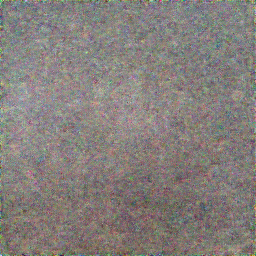


Step 50, output 0:


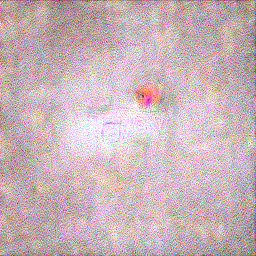


Step 100, output 0:


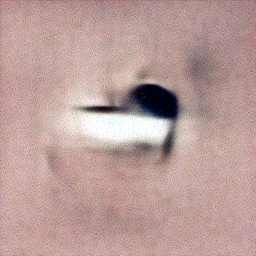


Step 150, output 0:


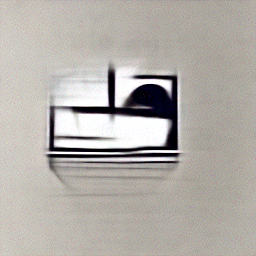


Step 200, output 0:


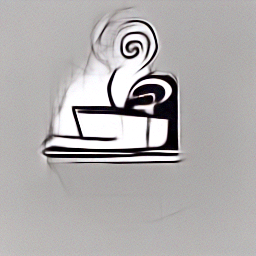


Step 250, output 0:


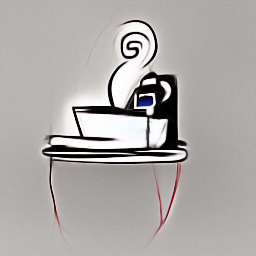


Step 300, output 0:


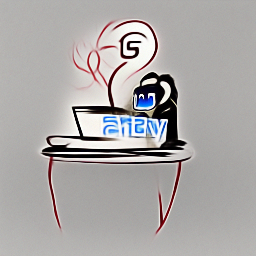


Step 350, output 0:


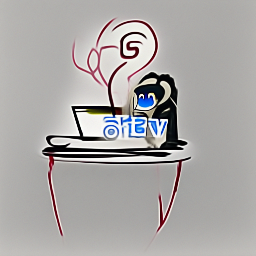


Step 400, output 0:


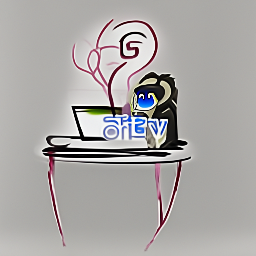


Step 450, output 0:


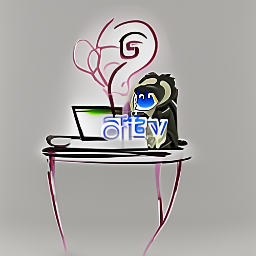


Step 499, output 0:


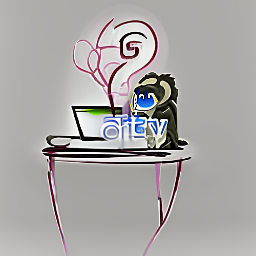

In [36]:
## 一个示例
prompt='一只坐在电脑前思考的猴子'
lang='cn'
generator(prompt,lang,t=0)